# Recomendação em Python
---
Um [Sistema de Recomendação](https://pt.wikipedia.org/wiki/Sistema_de_recomenda%C3%A7%C3%A3o) (ou **RecSys**, do acrônimo em inglês para *Recommendation System*) sugere itens relevantes a usuários baseado em suas preferências, sejam elas implícitas (inferidas a partir de suas interações em itens) ou explícitas (relevância expressamente informada por ele). As principais abordagens de recomendação reportadas na literatura são:

*   Baseada em Popularidade: recomenda aos usuários os itens mais populares dentre os que ele não conhece. Não personaliza a recomendação e se baseia na "sabedoria coletiva" (*[wisdom of the crowds](https://en.wikipedia.org/wiki/The_Wisdom_of_Crowds)*).
*   [Filtragem Colaborativa (Collaborative Filtering)](https://pt.wikipedia.org/wiki/Filtragem_colaborativa): realiza predições sobre o interesse de usuários a itens para filtrar os itens de maior interesse (filtragem) a partir do histórico completo de preferências de todos os usuários (colaborativa). Assume que a probabilidade de  usuários terem o mesmo interesse sobre itens é maior se esses usuários já tiveram interesses semelhantes por outros itens.
*   [Baseada em Conteúdo (Content-Based)](https://pt.wikipedia.org/wiki/Filtragem_baseada_em_conte%C3%BAdo): realiza predições a partir da similaridade entre os descritores de itens e de usuários. Recomenda items similares aos itens que o usuário já se interessou ou interessa. 
*   [Híbrida](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems): combinação das outras abordagens de recomendação com objetivo de minimizar problemas relacionados à esparsidade e [cold-start](https://en.wikipedia.org/wiki/Cold_start).

Aqui apresento implementações em [Python](https://www.python.org/) das principais abordagens de recomendação supra citadas, avaliando-as a partir de métodos e métricas de avaliação amplamente difundidos na literatura técnico-científica. Primeiramente, vamos carregar algumas bibliotecas necessárias para a implementação das abordagens:


In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fmart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Base de Dados

---

Precisamos definir o contexto da recomendação, bem como estabelecer uma base de dados para experimentação. Aqui utilizaremos o contexto de recomendação de livros e os dados de interação de usuários na plataforma Book Crossing. O dataset foi obtido a partir do site http://www2.informatik.uni-freiburg.de/~cziegler/BX/. Esta base é composta por três arquivos carregados a seguir. Como esta base não fornece uma descrição dos filmes, foi combinada uma segunda base de dados chamada Good Books Dataset, disponibilizada pela plataforma Kagle (https://www.kaggle.com/zygmunt/goodbooks-10k). Esta base possui uma descrição de palavras-chave relacionadas aos filmes. Foi necessário combinar as bases por ISBN, já que os livros não são correspondentes em 100% dos casos.

### Carregamento da Base de Dados
---
A base contém dados de agosto a setembro de 2004, coletados a partir de um crawler desenvolvido por Cai-Nicolas Ziegler. Possui 278.858 usuários, fornecendo 1.149.780 avaliações de cerca de 271.379 livros. A base de dados é composta por três inicialmente por três arquivos CSV carregados a seguir.

### Books.csv

Base de dados de livros do Book Crossing. Ela contém os atributos ISBN, título do livro, autor do livro, ano de publicação, editora e algumas imagens relacionadas. Foi selecionada uma amostra contendo os 10.000 primeiros livros desta base e adicionado um atributo (BookID) como índice da tabela.

In [2]:
#Carregamento da base de dados de livros - BookID foi adicionado ao arquivo original
items = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
items.columns = ['BookID','ISBN', 'BookTitle', 'BookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
items.head(10)

,BookID,ISBN,BookTitle,BookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,1,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,3,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,4,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,5,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,6,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,7,425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
7,8,671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...
8,9,679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...
9,10,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...


### BX-Book-Ratings.csv

Contém os registros da interação dos usuários com os livros com os campos UserID, ISBN e BookRating. Foi gerada uma nova versão deste arquivo que contém o BookID e   apenas as avalições de livros que estão definidos no arquivo de livros. Além disso, foi excluído o atributo ISBN pois não havia mais necessidade dele para o propósito deste trabalho. As avaliações variam de 0 a 10. No entanto, as classificações são muito desigualmente distribuídas e a grande maioria das delas é igual a 0. Veja no gráfico.


In [3]:
#Carregamento da base de dados de avaliações
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['UserID', 'BookID', 'BookRating']
print('Ratings: ',len(ratings))
print ('# Usuários: %d' % ratings.UserID.unique().shape[0])
ratings.head(10)

Ratings:  36887
# Usuários: 15143


,UserID,BookID,BookRating
0,8,10,5
1,8,12,0
2,8,14,5
3,8,15,0
4,8,16,6
5,8,17,6
6,8,18,7
7,12,23,10
8,22,33,7
9,22,34,0


In [4]:
#Ordenação das avaliações por usuário e id do livro
ratings.sort_values(by=['UserID', 'BookID']).head(10)

,UserID,BookID,BookRating
0,8,10,5
1,8,12,0
2,8,14,5
3,8,15,0
4,8,16,6
5,8,17,6
6,8,18,7
7,12,23,10
8,22,33,7
9,22,34,0


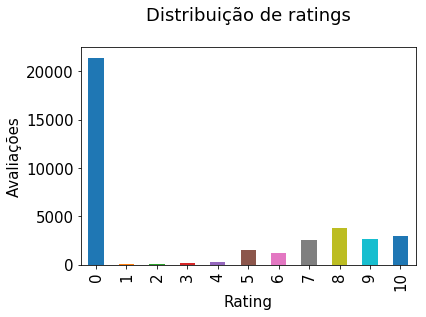

In [5]:
#Distribuição dos ratings. Veja que a maioria dos ratings são iguais a 0.
plt.rc("font", size=15)
ratings['BookRating'].value_counts(sort=False).plot(kind='bar')
plt.title('Distribuição de ratings\n')
plt.xlabel('Rating')
plt.ylabel('Avaliações')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

### BX-Users.csv
Base de dados de usuários. Contém 278.858 usuários com os atributos UserID, Location e Age.


In [6]:
#Vamos carregar a base de dados de usuários
users = pd.read_csv('BX-Users.csv', sep=';', encoding="latin-1")
users.columns = ['UserID', 'Location', 'Age']
print('Total de usuários: ', len(users))
users.head(5)

Total de usuários:  278858


,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


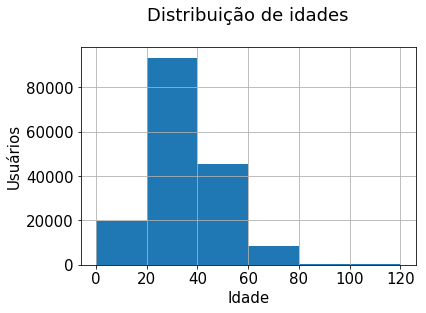

In [7]:
#Gráfico de distribuição de idades. Os mais ativos estão entre 20 e 30 anos
users.Age.hist(bins=[0,20,40,60,80,100,120])
plt.title('Distribuição de idades\n')
plt.xlabel('Idade')
plt.ylabel('Usuários')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

Um novo arquivo de usuários foi gerado para separar Cidade, Estado e País. Assim pode-se fazer filtros mais específicos com os observado a seguir.

In [8]:
#Vamos carregar a base de dados de usuários mais detalhada
users_location = pd.read_csv('BX-Users-Location.csv', sep=';', encoding="latin-1")
users_location.columns = ['UserID', 'Age', 'City', 'State', 'Country']
users_location.head(5)

,UserID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [9]:
users_location_count =  pd.DataFrame(users_location.groupby('Country')['Country'].count())
most_users_location = users_location_count.sort_values('Country', ascending=False)
most_users_location.columns = ['UsersNumber']
most_users_location.head(10)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'Country' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,UsersNumber
Country,
usa,139187
canada,21558
united kingdom,18286
germany,17022
spain,13095
australia,11723
italy,11241
france,3442
portugal,3306


### Transformação da Base de Dados
---
O processo de transformação de dados a fim de torná-los apropriados para análise ([data wrangling](https://en.wikipedia.org/wiki/Data_wrangling)) é muitas vezes necessário. Nesse caso, a base de dados apresenta algumas características que devem ser tratadas para que as abordagens de recomendação possam ser efetivamente aplicadas. 

Recomendadores comumente enfrentam um problema conhecido como cold-start, em que é difícil prover sugestões personalizadas para usuários com nenhuma ou pouquíssimas interações no sistema, uma vez que tem-se pouca informação para modelar suas preferências. Como o foco aqui não está no tratamento do problema de cold-start, para minimizar seu efeito na recomendação utilizaremos usuários com pelo menos 5 interações no sistema.

In [10]:
users_interactions_count_df = ratings.groupby(['UserID', 'BookID']).size().groupby('UserID').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['UserID']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))


# users: 15143
# users with at least 5 interactions: 1510


In [11]:
print('# of interactions: %d' % len(ratings))
interactions_from_selected_users_df = ratings.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'UserID',
               right_on = 'UserID')

print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 36887
# of interactions from users with at least 5 interactions: 17974


#### Remoção de Duplicatas

---

Vamos dar uma olhada nos nossos registros de itens na base de dados:

In [12]:
print ('# itens: %d' % items.BookID.shape[0])
print ('# itens únicos: %d' % items.BookID.unique().shape[0])

# itens: 10000
# itens únicos: 10000


In [13]:
items = items.drop_duplicates(subset='BookID',keep='first')
print('# itens: %d' % len(items))

# itens: 10000


#### Tratamento de Ausentes

---

Agora vamos dar uma olhada no número de usuários que atribuíram *ratings* a itens e no número de itens com *ratings* atribuídos:

In [14]:
print ('# Itens: %d' % interactions_from_selected_users_df.BookID.unique().shape[0])
print ('# Usuários: %d' % interactions_from_selected_users_df.UserID.unique().shape[0])

# Itens: 1828
# Usuários: 1510


Como podemos observar, na base de dados existem *ratings* de usuários em itens que não estão presentes no arquivo de itens. Dessa forma, para evitar problemas de *matching* (casamento de identificadores de itens em arquivos), eliminaremos os 55.015 *ratings* de usuários em itens ausentes:

In [15]:
interactions_from_selected_users_df = interactions_from_selected_users_df.merge(items, on='BookID')[['UserID','BookID','BookRating']]
print('# ratings: %d' % len(interactions_from_selected_users_df))

# ratings: 17971


Vamos dar uma olhada novamente no número de usuários que fizeram avaliações e no número de itens que foram avaliados:

In [16]:
print ('# itens: %d' % interactions_from_selected_users_df.BookID.unique().shape[0])
print ('# usuarios: %d' % interactions_from_selected_users_df.UserID.unique().shape[0])

# itens: 1827
# usuarios: 1510


Foi calculada a dispesão da base de dados de avaliações. Observe que o valor é significantemente alto, o que significa que a maioria das avaliações é igual a NaN. Como a maioria dos algoritmos de aprendizado de máquina não pode lidar com NaNs, foram substituídos por 0, que agora indica ausência de classificação. A base de dados já foi obtida com esta mudança.

In [17]:
#Dispersão da base de dados Book Crossing
sparsity=1.0-len(interactions_from_selected_users_df)/float(users.shape[0]*items.shape[0])
print('O nível de dispersão da base de dados Book Crossing é ' +  str(sparsity*100) + ' %')

O nível de dispersão da base de dados Book Crossing é 99.99935555013663 %


### Mais algumas análises da base de dados antes de iniciarmos as abordagens.

In [18]:
#Vamos visualizar os cinco livros mais avaliados
rating_count =  pd.DataFrame(interactions_from_selected_users_df.groupby('BookID')['BookRating'].count())
most_rated_books = rating_count.sort_values('BookRating', ascending=False)
most_rated_books.columns=['TotalRatingCount']
most_rated_books.head(10)

,TotalRatingCount
BookID,
1923,267
457,262
2144,250
306,227
1407,200
406,184
1013,184
4181,183
3784,173


In [19]:
#Detalhes dos 5 livros mais avaliados
most_rated_books_summary = pd.merge(most_rated_books,items, on='BookID')[['BookID', 'BookTitle','ISBN']]
most_rated_books_summary.head()

,BookID,BookTitle,ISBN
0,1923,Snow Falling on Cedars,067976402X
1,457,The Firm,044021145X
2,2144,Harry Potter and the Sorcerer's Stone (Harry P...,059035342X
3,306,A Painted House,044023722X
4,1407,The No. 1 Ladies' Detective Agency (Today Show...,1400034779


Observe que o livro "Snow Falling on Cedars	" foi o mais avaliado. No entanto, observe abaixo que ele não foi altamente classificado,
nos mostra uma recomendação baseada apenas e contagens de avaliações é ineficiente.

In [20]:
#Vamos computar a classificação média e o número de classificações que cada livro recebeu.
#Observe que neste conjunto de dados, o livro que recebeu mais contagens de classificação não foi altamente classificado. 

average_rating = pd.DataFrame(interactions_from_selected_users_df.groupby('BookID')['BookRating'].mean())
average_rating['RatingCount'] = pd.DataFrame(interactions_from_selected_users_df.groupby('BookID')['BookRating'].count())
average_rating.sort_values('RatingCount', ascending=False).head()

,BookRating,RatingCount
BookID,,
1923,1.962547,267
457,2.408397,262
2144,3.776000,250
306,1.942731,227
1407,2.445000,200


Vejamos as estatísticas da contagem total de avaliações:

In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(most_rated_books['TotalRatingCount'].describe())

count   1827.000
mean       9.836
std       22.684
min        1.000
25%        1.000
50%        3.000
75%        8.000
max      267.000
Name: TotalRatingCount, dtype: float64


Para finalizar esta etapa, vamos apenas testar um filtro dos usuários por localização

In [22]:
#Filtro de usuários por localização (USA ou Canadá)
us_canada_user_rating = users[users['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head(10)

,UserID,Location
0,1,"nyc, new york, usa"
1,2,"stockton, california, usa"
5,6,"santa monica, california, usa"
6,7,"washington, dc, usa"
7,8,"timmins, ontario, canada"
8,9,"germantown, tennessee, usa"
11,12,"fort bragg, california, usa"
13,14,"mediapolis, iowa, usa"
14,15,"calgary, alberta, canada"
15,16,"albuquerque, new mexico, usa"


## Abordagens de Recomendação
---
A seguir apresento quatro abordagens de recomendação: abordagem baseada em popularidade (PB), abordagem baseada em filtragem colaborativa (CF), abordagem baseada em conteúdo (CB) e abordagem híbrida (HB). Para a abordagem de filtragem colaborativa, foram implementadas quatro diferentes estratégias: baseada em usuário (CF-UB), baseada em item (CF-IB) e baseada em fatoração de matriz utilizando [decomposição de valores singulares](https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_em_valores_singulares) (CF-SVD).

### Baseada em Popularidade
Por ser simples de entender e fácil de implementar, esta abordagem ainda é muito utilizada, uma vez que frequentemente provê boas recomendações, especialmente para usuários iniciantes sem interesses específicos. Entretanto, um dos principais objetivos da recomendação é a personalização, a fim de oferecer itens que atendam a interesses específicos (e não muito populares) dos usuários (*[long-tail](https://pt.wikipedia.org/wiki/Cauda_longa) itens*). Veja aqui um artigo interessante sobre [os desafios de prover novidade na recomendação, considerando itens na cauda-longa (*long-tail*)](http://vldb.org/pvldb/vol5/p896_hongzhiyin_vldb2012.pdf).


Primeiramente, vamos computar a popularidades dos itens:

In [23]:
itemPopularityDF = interactions_from_selected_users_df.groupby('BookID')['BookRating'].sum().sort_values(ascending=False).reset_index()
itemPopularityDF.columns = ['BookID', 'Score']
itemPopularityDF.sort_values(ascending=False,by=['Score']).head(10)

,BookID,Score
0,2144,944
1,5507,740
2,457,631
3,1923,524
4,1407,489
5,306,441
6,5071,435
7,5580,431
8,4181,414
9,3235,351


Agora, vamos implementar a abordagem de recomendação baseada em popularidade:

In [24]:
class PBRecommender:
    
    def __init__(self, modelName, itemPopularityDF, itemsDF=None):
        self.modelName = modelName 
        self.itemPopularityDF = itemPopularityDF
        self.itemsDF = itemsDF
        
    def getModelName(self):
        return self.modelName
        
    def recommend(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendationsDF = self.itemPopularityDF[~self.itemPopularityDF['BookID'].isin(items_to_ignore)] \
                            .sort_values('Score', ascending = False) \
                            .head(topn)
        if verbose:
            if self.itemsDF is None:
                raise Exception(' The items data frame (itemsDF) is required in verbose mode')
            recommendationsDF = recommendationsDF.merge(self.itemsDF, how = 'left', 
                                                        left_on = 'BookID', 
                                                        right_on = 'BookID')[['BookID', 'BookTitle', 'Score']]
        return recommendationsDF

In [25]:
PBModel = PBRecommender('PB',itemPopularityDF, items)

Finalmente, vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [150]:
recommendedItensPB = PBModel.recommend(4017, topn=10, verbose=True)
recommendedItensPB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,2144,Harry Potter and the Sorcerer's Stone (Harry P...,944
1,5507,Harry Potter and the Order of the Phoenix (Boo...,740
2,457,The Firm,631
3,1923,Snow Falling on Cedars,524
4,1407,The No. 1 Ladies' Detective Agency (Today Show...,489
5,306,A Painted House,441
6,5071,Bridget Jones's Diary,435
7,5580,Tears of the Giraffe (No.1 Ladies Detective Ag...,431
8,4181,The Bridges of Madison County,414
9,3235,"A Child Called \It\"": One Child's Courage to S...",351


### Filtragem Colaborativa
Abordagens de filtragem colaborativa comumente adotam duas estratégias diferentes:



*   Baseada em Memória ([*memory-based*](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based)): usa a memória de *ratings* passados para computar similaridades entre usuários baseado nos itens em que eles atribuíram *rating* (*user-based*), ou para computar similaridades entre itens baseado nos usuários que atribuíram *rating* a esses itens (*item-based*). Um exemplo dessa estratégia é a Filtragem Colaborativa baseada na Vizinhança de Usuário, onde os *top-k* usuários mais similares a um usuário específico são selecionados e usados para sugerir itens de interesse para o usuário específico, desde que ele ainda não tenha atribuído *rating* aos itens. Apesar de ser simples de implementar, essa estratégia é cara computacionalmente quando se tem muitos usuários. 
*   Baseada em Modelo ([*model-based*](https://en.wikipedia.org/wiki/Collaborative_filtering#Model-based)): modelos são construídos usando diferentes algoritmos de aprendizagem [supervisionada](https://en.wikipedia.org/wiki/Supervised_learning) e [não-supervisionada](https://en.wikipedia.org/wiki/Unsupervised_learning) para sugerir itens a usuários. Para a construção de modelos podemos utilizar inúmeras abordagens, como redes neurais ([*neural networks*](https://en.wikipedia.org/wiki/Artificial_neural_network)), redes bayesianas ([*bayesian networks*](https://en.wikipedia.org/wiki/Bayesian_network)), agrupamento ([*clustering*](https://en.wikipedia.org/wiki/Cluster_analysis)), e fatores latentes (*latent factor models*), tais como [*Singular-Value Decomposition (SVD)*](https://en.wikipedia.org/wiki/Singular-value_decomposition) e [*probabilistic latent semantic analysis*](https://en.wikipedia.org/wiki/Probabilistic_latent_semantic_analysis).

Independentemente da estratégia, as abordagens de filtragem colaborativa usam uma representação matricial dos *ratings* de usuários em itens para computar os *ratings* ausentes. Abaixo criaremos uma matriz de usuário-itens, onde nas linhas temos usuários, nas colunas itens e em cada célula da matriz o *rating* de usuários em itens:

In [151]:
#Creating a sparse pivot users-items table
usersItemsDF = interactions_from_selected_users_df.pivot(index='UserID',columns='BookID').BookRating.fillna(0)
usersItemsMatrix = usersItemsDF.as_matrix()
usersItemsMatrix[:10]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[5., 0., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Com base na representação matricial de *ratings* de usuários em itens, podemos extrair informação sobre usuários e itens, tal como a lista de todos os usuários que atribuíram *rating* a itens:

In [152]:
usersIds = list(usersItemsDF.index)
usersIds[:10]

[8, 242, 243, 254, 383, 388, 392, 446, 505, 507]

A partir daí podemos implementar a abordagem de filtragem colaborativa para recomendação:

In [153]:
class CFRecommender:
      
    def __init__(self, modelName, CFPredictionsDF, itemsDF=None):
        self.modelName = modelName
        self.CFPredictionsDF = CFPredictionsDF
        self.itemsDF = itemsDF
        
    def getModelName(self):
        return self.modelName
        
    def recommend(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.CFPredictionsDF[user_id].sort_values(ascending=False) \
                                  .reset_index().rename(columns={user_id: 'Score'})
        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendationsDF = sorted_user_predictions[~sorted_user_predictions['BookID'].isin(items_to_ignore)] \
                            .sort_values('Score', ascending = False) \
                            .head(topn)
        if verbose:
            if self.itemsDF is None:
                raise Exception('The items data frame (itemsDF) is required in verbose mode')
            recommendationsDF = recommendationsDF.merge(self.itemsDF, how = 'left', 
                                                        left_on = 'BookID', 
                                                        right_on = 'BookID')[['BookID', 'BookTitle', 'Score']]
        return recommendationsDF

#### Baseada em Usuário
Estratégias de filtragem colaborativa baseadas em usuário utilizam os *ratings* de usuários similares a um usuário alvo para estimarem o interesse desse usuário alvo a itens que ele não atribuiu *rating*. Uma métrica de distância comumente utilizada para cálculo de similaridade é o coseno. Nesse caso, usuários são representados como vetores em um espaço $n$-dimensional e a similaridade entre eles é calculada usando o coseno do ângulo entre os vetores:

In [154]:
usersSimilarity = pairwise_distances(usersItemsMatrix, metric='cosine')

Uma vez calculada as similaridades entre usuários, podemos utiliza-las para computar as predições de *ratings* ausentes, estimando assim os *ratings* que usuários atribuiriam a itens ainda sem *rating*:

In [155]:
meanUserRating = usersItemsMatrix.mean(axis=1)
DiffRating = (usersItemsMatrix - meanUserRating[:, np.newaxis])
predictedRatings = meanUserRating[:, np.newaxis] + usersSimilarity.dot(DiffRating) / np.array([np.abs(usersSimilarity).sum(axis=1)]).T
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
CFPredictionsDF.head(10)

,8,242,243,254,383,388,392,446,505,507,...,275970,276018,276463,276670,276925,276929,276994,277427,278144,278418
BookID,,,,,,,,,,,,,,,,,,,,,
10,0.000,0.088,-0.005,-0.002,-0.009,0.006,0.020,-0.003,0.005,-0.008,...,0.014,-0.002,0.001,-0.008,-0.007,-0.004,0.004,-0.008,-0.012,-0.005
12,0.000,0.085,-0.009,-0.006,-0.013,0.003,0.017,-0.007,0.002,-0.012,...,0.011,-0.006,-0.002,-0.011,-0.010,-0.007,0.000,-0.011,-0.016,-0.009
14,0.000,0.088,-0.005,-0.002,-0.009,0.006,0.020,-0.003,0.005,-0.008,...,0.014,-0.002,0.001,-0.008,-0.007,-0.004,0.004,-0.008,-0.012,-0.005
15,0.000,0.085,-0.009,-0.006,-0.013,0.003,0.017,-0.007,0.002,-0.012,...,0.011,-0.006,-0.002,-0.011,-0.010,-0.007,0.000,-0.011,-0.016,-0.009
16,0.000,0.089,-0.005,-0.002,-0.009,0.007,0.021,-0.003,0.006,-0.008,...,0.015,-0.002,0.002,-0.007,-0.006,-0.003,0.004,-0.007,-0.012,-0.005
17,0.000,0.089,-0.005,-0.002,-0.009,0.007,0.021,-0.003,0.006,-0.008,...,0.015,-0.002,0.002,-0.007,-0.006,-0.003,0.004,-0.007,-0.012,-0.005
18,0.000,0.089,-0.004,-0.001,-0.008,0.008,0.021,-0.002,0.007,-0.007,...,0.016,-0.001,0.002,-0.006,-0.005,-0.003,0.005,-0.006,-0.011,-0.004
23,0.000,0.085,-0.009,-0.006,-0.013,0.003,0.017,-0.007,0.002,-0.012,...,0.011,-0.006,-0.002,-0.011,-0.010,-0.007,0.000,-0.011,-0.016,-0.009
41,0.006,0.090,-0.003,-0.000,-0.007,0.008,0.022,-0.001,0.007,-0.006,...,0.016,-0.000,0.003,-0.006,-0.005,-0.002,0.006,-0.006,-0.010,-0.003


Finalmente, vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [156]:
UBModel = CFRecommender('CF-UB',CFPredictionsDF, items)

In [157]:
recommendedItensUB = UBModel.recommend(4017, topn=10, verbose=True)
recommendedItensUB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,2144,Harry Potter and the Sorcerer's Stone (Harry P...,0.703
1,5507,Harry Potter and the Order of the Phoenix (Boo...,0.568
2,457,The Firm,0.491
3,1407,The No. 1 Ladies' Detective Agency (Today Show...,0.399
4,306,A Painted House,0.370
5,1923,Snow Falling on Cedars,0.368
6,5580,Tears of the Giraffe (No.1 Ladies Detective Ag...,0.359
7,4181,The Bridges of Madison County,0.349
8,5071,Bridget Jones's Diary,0.324
9,3235,"A Child Called \It\"": One Child's Courage to S...",0.307


#### Baseada em Item
Estratégias de filtragem colaborativa baseadas em item utilizam os *ratings* que o usuário atribuiu a diversos itens para estimarem o interesse do usuário a itens semelhantes aos que ele atribuiu melhores *ratings*. Similarmente à estratégia baseada em usuário, podemos utilizar a distância por coseno para calcular a similaridade entre itens:

In [158]:
itemsSimilarity = pairwise_distances(usersItemsMatrix.T, metric='cosine')

Tal como na estratégia baseada em usuário, uma vez que calculada as similaridades entre itens, podemos utiliza-las para computar as predições de *ratings* ausentes, estimando assim os *ratings* que usuários atribuiriam a itens ainda sem *rating*:

In [159]:
predictedRatings = usersItemsMatrix.dot(itemsSimilarity) / np.array([np.abs(itemsSimilarity).sum(axis=1)])
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
CFPredictionsDF.head(5)

,8,242,243,254,383,388,392,446,505,507,...,275970,276018,276463,276670,276925,276929,276994,277427,278144,278418
BookID,,,,,,,,,,,,,,,,,,,,,
10,0.000,0.100,0.007,0.010,0.003,0.019,0.032,0.009,0.018,0.004,...,0.026,0.010,0.013,0.004,0.005,0.008,0.016,0.004,0.000,0.007
12,0.016,0.100,0.007,0.010,0.003,0.019,0.032,0.009,0.018,0.004,...,0.026,0.010,0.013,0.004,0.005,0.008,0.016,0.004,0.000,0.007
14,0.000,0.100,0.007,0.010,0.003,0.019,0.032,0.009,0.018,0.004,...,0.026,0.010,0.013,0.004,0.005,0.008,0.016,0.004,0.000,0.007
15,0.016,0.100,0.007,0.010,0.003,0.019,0.032,0.009,0.018,0.004,...,0.026,0.010,0.013,0.004,0.005,0.008,0.016,0.004,0.000,0.007
16,0.000,0.100,0.007,0.010,0.003,0.019,0.032,0.009,0.018,0.004,...,0.026,0.010,0.013,0.004,0.005,0.008,0.016,0.004,0.000,0.007


Vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados (usuário teste de número 4017, que possui 48 anos de idade e é morador de New Orleans, estado de Luisiania nos EUA):

In [160]:
IBModel = CFRecommender('CF-IB',CFPredictionsDF, items)

In [161]:
recommendedItensIB = IBModel.recommend(4017, topn=10, verbose=True)
recommendedItensIB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,9620,Lightning,0.095
1,596,Guilty as Sin,0.095
2,593,The Partner,0.095
3,2692,Montana Sky,0.095
4,1107,She's Come Undone (Oprah's Book Club (Paperback)),0.095
5,5756,The Villa,0.095
6,1196,Jurassic Park,0.095
7,6622,Timeline,0.095
8,505,The Sky Is Falling,0.095
9,3792,The Pelican Brief,0.095


#### Fatoração de Matriz
Modelos de [fatores latentes](https://en.wikipedia.org/wiki/Latent_variable) são capazes de comprimir a matriz usuário-item em uma representação matricial de baixa dimensionalidade. A principal vantagem de se usar essa técnica é a substituição de uma matriz esparsa de alta dimensionalidade por uma matriz densa de baixa dimensionalidade. Essa representação reduzida pode ser tanto utilizada em estratégias baseadas em vizinhança de usuário (*user-based*), quanto em vizinhança de itens (*item-based*). Particularmente, esses modelos tratam o problema de esparsidade melhor que os modelos baseados em memória e os cálculos de similaridade na matriz de baixa dimensionalidade resultante são mais eficientes e escaláveis.

Aqui usaremos a implementação [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) de um modelo de fatores latentes popular denominado [*Singular-Value Decomposition (SVD)*](https://en.wikipedia.org/wiki/Singular-value_decomposition). Cabe ressaltar que existem diversos *frameworks* para fatoração de matrizes específicos para filtragem colaborativa, como [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec) e [python-recsys](https://github.com/ocelma/python-recsys). Veja outro [exemplo de SVD para recomendação de filmes](https://beckernick.github.io/matrix-factorization-recommender/).

Um importante parâmetro da fatoração é o número de fatores utilizados para fatorar a matriz. Quanto maior o número de fatores, mais precisa será a fatoração para reconstrução da matriz original. Entretanto, se o modelo "memorizar" muitos detalhes da matriz original, ele pode perder capacidade de generalização. Em suma, o aumento  do número de fatores aumenta a precisão, enquanto a redução do número de fatores aumenta a capacidade de generalização do modelo. Aqui usaremos 15 fatores:

In [162]:
U, sigma, Vt = svds(usersItemsMatrix, k=15)
sigma = np.diag(sigma)

In [163]:
U.shape

(1510, 15)

In [164]:
Vt.shape

(15, 1827)

In [165]:
sigma.shape

(15, 15)

Após a fatoração matricial, podemos reconstruir a matriz original através da multiplicação de seus fatores. A matriz resultante será uma aproximação da matriz original, porém não será mais tão esparsa, apresentando valores para itens sobre os quais os usuários não atribuíram *rating*, o que poderá ser explorado para recomendação.

In [166]:
predictedRatings = np.dot(np.dot(U, sigma), Vt) 
predictedRatings

array([[ 1.94569697e-32,  0.00000000e+00,  1.94569697e-32, ...,
         1.55166086e-17,  0.00000000e+00, -3.03609447e-17],
       [-3.09398779e-18,  0.00000000e+00, -3.09398779e-18, ...,
         4.89882492e-03,  0.00000000e+00,  8.86885208e-02],
       [-9.35583462e-19,  0.00000000e+00, -9.35583462e-19, ...,
        -1.49016542e-02,  0.00000000e+00, -6.86243046e-03],
       ...,
       [-1.16943911e-21,  0.00000000e+00, -1.16943911e-21, ...,
        -4.77275644e-05,  0.00000000e+00,  8.06984532e-05],
       [ 8.99387401e-36,  0.00000000e+00,  8.99387401e-36, ...,
        -8.87447497e-20,  0.00000000e+00, -5.25538123e-18],
       [ 6.77687627e-18,  0.00000000e+00,  6.77687627e-18, ...,
         4.24808787e-03,  0.00000000e+00,  2.79514551e-02]])

In [167]:
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
CFPredictionsDF.head(5)

,8,242,243,254,383,388,392,446,505,507,...,275970,276018,276463,276670,276925,276929,276994,277427,278144,278418
BookID,,,,,,,,,,,,,,,,,,,,,
10,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
12,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
15,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000


Agora vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [168]:
SVDModel = CFRecommender('CF-SVD',CFPredictionsDF, items)

In [170]:
recommendedItensSVD = SVDModel.recommend(4017, topn=10, verbose=True)
recommendedItensSVD.sort_values(ascending=False,by=['Score']).head(20)

,BookID,BookTitle,Score
0,1923,Snow Falling on Cedars,14.064
1,648,Angela's Ashes: A Memoir,9.818
2,3784,STONES FROM THE RIVER,9.742
3,5071,Bridget Jones's Diary,6.819
4,1307,The Color of Water: A Black Man's Tribute to H...,5.692
5,1421,"Breath, Eyes, Memory",3.579
6,4578,What Looks Like Crazy On An Ordinary Day,3.553
7,2545,How to Be Good,3.508
8,968,Charming Billy,3.368
9,716,Strange Fits of Passion: A Novel,2.989


### Baseada em Conteúdo
Abordagens de recomendação baseadas em conteúdo levam em conta a descrição (ou atributos) de itens relevantes a usuários para sugerir itens similares. Elas consideram apenas escolhas prévias do próprio usuário, o que as torna resilientes ao problema de  [cold-start](https://en.wikipedia.org/wiki/Cold_start). Para recomendação de itens com farto conteúdo textual, como artigos, livros e notícias, o uso do texto associado ao item para construir perfis de itens e usuários se mostra uma tarefa muito simples e intuitiva.

Aqui utilizaremos um modelo clássico de recuperação de informação para representação de itens e usuários, o [modelo vetorial](https://pt.wikipedia.org/wiki/Modelo_vetorial_em_sistemas_de_recupera%C3%A7%C3%A3o_da_informa%C3%A7%C3%A3o). Nesse modelo, textos não estruturados são convertidos em vetores de palavras, onde cada palavra é representada por uma posição no vetor e o valor nessa posição indica a importância (peso) da palavra no texto. Como todos os itens e usuários são representados em um espaço vetorial, o cálculo de similaridade entre itens e usuários pode ser feito utilizando o cosseno ([cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)) entre seus respectivos vetores. Para o cálculo do peso das palavras no texto geralmente utiliza-se o [esquema TF-IDF](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf), onde a frequência da palavra no texto e a raridade da palavra entre os diversos textos determinam sua importância.

Aqui foi realizado o cruzamento das bases Book Crossing e Good Books. O cógigo a seguir foi utilizado uma única vez na criação de um arquivo CSV contendo todas as palavras chave dos livros, a partir de content_full_df. Antes disso, não mostrado aqui, foi feito um cruzamento das bases pelo ISBN. Isso foi necessário para a implementação da recomendação por conteúdo, uma vez que ela será feita com base nas palavras chave dos livros que os usuários interagiram.

import csv
import pandas as pd

book_tags_df = pd.read_csv('book_tags.csv', delimiter=';')
tags_df = pd.read_csv('tags.csv', delimiter=';')
content_df = pd.merge(itemsDF, book_tags_df, on='goodreads_book_id')
content_full_df = pd.merge(content_df, tags_df, on='tag_id')

content = pd.DataFrame(content_full_df, columns = ['book_id','goodreads_book_id','best_book_id','work_id','books_count','isbn','isbn13','authors','original_publication_year','original_title','ratings_1','ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url','tag_id','count','tag_name'])

content = pd.DataFrame(content_full_df, columns = ['BookID','ISBN','BookTitle', 'tag_name'])

content.to_csv('BX-Content.csv')

In [46]:
#Carregamento da base de dados de livros com as palavras chave. A listagem mostra cada interação do livro com a palavra chave
content = pd.read_csv('BX-Content.csv', sep=';')
content.head(10)

,BookID,ISBN,BookTitle,tag_name
0,19,440234743,The Testament,to-read
1,21,609804618,Our Dumb Century: The Onion Presents 100 Years...,to-read
2,45,553582909,Icebound,to-read
3,46,671888587,I'll Be Seeing You,to-read
4,47,553582747,From the Corner of His Eye,to-read
5,52,842342702,Left Behind: A Novel of the Earth's Last Days ...,to-read
6,75,345465083,Seabiscuit,to-read
7,78,441783589,Starship Troopers,to-read
8,79,394895894,"The Ruby in the Smoke (Sally Lockhart Trilogy,...",to-read
9,106,067976397X,Corelli's Mandolin : A Novel,to-read


In [47]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = content['BookID'].tolist()
tfIdfMatrix = vectorizer.fit_transform(content['BookTitle'] + "" + content['tag_name'])
tfIdfFeatureNames = vectorizer.get_feature_names()
tfIdfMatrix

<58697x413 sparse matrix of type '<class 'numpy.float64'>'
	with 160745 stored elements in Compressed Sparse Row format>

Para modelar o perfil de usuário, utilizaremos todos os perfis de itens que o usuário atribuiu *rating*. Mais especificamente, o vetor de palavras representativos de um usuário será constituído por todas as palavras presentes nos vetores de itens que o usuário atribuiu *rating* e os pesos de cada palavra serão determinados pelo TF-IDF ponderado pelo *rating* do usuário.

In [48]:
#Observe que um novo arquivo de ratings teve que ser gerado, para conter apenas as avaliações de livros que possuem palavras
#-chave
ratings_content = pd.read_csv('BX-Book-Ratings-Content.csv', sep=';')
ratings_content.columns = ['UserID', 'BookID','BookRating']
print("Ratings de usuários com pelo menos 5 interações e de livros que possuem palavras-chave: ", len(ratings_content))

Ratings de usuários com pelo menos 5 interações e de livros que possuem palavras-chave:  7181


In [49]:

def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfIdfMatrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(user_id, interactions_indexed_df):
   
    interactions_user_df = interactions_indexed_df

    user_item_profiles = get_item_profiles(interactions_user_df['BookID'])  
    user_item_strengths = np.array(interactions_user_df['BookRating']).reshape(-1,1)
    
    #Weighted average of item profiles by the interactions strength
    if (user_item_profiles.shape[0] == user_item_strengths.shape[0]):
        user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
        user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
        return user_profile_norm
    

def build_users_profiles(): 
    interactions_indexed_df = ratings_content[ratings_content['BookID'] \
                                                   .isin(items['BookID'])].set_index('UserID')
    user_profiles = {}
    for user_id in interactions_indexed_df.index.unique():
        user_profiles[user_id] = build_users_profile(user_id, interactions_indexed_df)
    return user_profiles

In [50]:
userProfiles = build_users_profiles() 
len(userProfiles)

4424

Para simplificar e tornar os cálculos mais rápidos, faremos uma poda nos vetores de palavras e fixaremos o tamanho máximo do vetor em 5.000 palavras. Observando o perfil de um usuário específico, espera-se que as palavras mais representativas no perfil do usuário estejam realmente relacionadas aos conceitos que o usuário se interessa. 

In [51]:
user1 = userProfiles[4017]
pd.DataFrame(sorted(zip(tfIdfFeatureNames, 
                        userProfiles[4017].flatten().tolist()), key=lambda x: -x[1])[:10],
             columns=['token', 'relevance'])

,token,relevance
0,read,0.975
1,falling,0.086
2,snow,0.086
3,called,0.051
4,one,0.047
5,agency,0.041
6,detective agency,0.041
7,ladies,0.041
8,ladies detective,0.041
9,detective,0.037


Agora, vamos implementar a abordagem de recomendação baseada em conteúdo:

In [52]:
class CBRecommender:
    
    def __init__(self, modelName, itemsDF=None):
        self.modelName = modelName
        self.item_ids = item_ids
        self.itemsDF = itemsDF
        
    def getModelName(self):
        return self.modelName
        
    def _getSimilarItems(self, user_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(userProfiles[user_id], tfIdfMatrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._getSimilarItems(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        recommendationsDF = pd.DataFrame(similar_items_filtered, columns=['BookID', 'Score']) \
                                         .head(topn)
        if verbose:
            if self.itemsDF is None:
                raise Exception('The items data frame (itemsDF) is required in verbose mode')
            recommendationsDF = recommendationsDF.merge(self.itemsDF, how = 'left', 
                                                        left_on = 'BookID', 
                                                        right_on = 'BookID')[['BookID', 'BookTitle','Score']]
        return recommendationsDF

In [53]:
CBModel = CBRecommender('CB',items)

Finalmente, vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [54]:
recommendedItensCB = CBModel.recommend(4017, topn=10, verbose=True)
#A linha a seguir foi adicionada pois como mais os filmes possuem mais de uma palavra que pode ser relevante para o usuário
#o livro poderia aparecer repetido na lista
recommendedItensCB = recommendedItensCB.drop_duplicates(subset='BookID',keep='first')
recommendedItensCB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,7541,Awakening the Buddha Within : Tibetan Wisdom f...,0.975
1,3482,Timbuktu : A Novel,0.975
2,3300,Without Remorse,0.975
3,1494,The Fountainhead,0.975
4,1674,The Sparrow,0.975
5,8713,The List,0.975
6,2037,An Acceptable Time,0.975
7,4275,The Sicilian,0.975
8,1573,Watership Down,0.975
9,2027,Written on the Body,0.975


### Híbrida
Abordagens híbridas têm apresentado melhores resultados que abordagens puras em muitos casos reais e por esse motivo têm sido muito utilizadas na prática. Aqui, implementaremos uma abordagem híbrida simples obtida usando a multiplicação dos pesos das abordagens de filtragem colaborativa com fatoração de matriz e por popularidade previamente apresentadas, para prover um ranking obtido a partir dos pesos combinados.

In [174]:
class HBRecommender:
    
    def __init__(self, modelName, SVDModel, PBmodel, itemsDF):
        self.modelName = modelName
        self.SVDModel = SVDModel
        self.PBmodel = PBmodel
        self.itemsDF = itemsDF
        
    def getModelName(self):
        return self.modelName
        
    def recommend(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 SVD recommendations
        SVDRecommendationsDF = self.SVDModel.recommend(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'Score': 'ScoreUB'})
        
        #Getting the top-1000 Popularity recommendations
        PBRecommendationsDF = self.PBmodel.recommend(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                             topn=1000).rename(columns={'Score': 'ScorePB'})
        
        #Combining the results by contentId
        HBRecommendationsDF = SVDRecommendationsDF.merge(PBRecommendationsDF,
                                                        how = 'inner', 
                                                        left_on = 'BookID', 
                                                        right_on = 'BookID')
        
        #Computing a hybrid recommendation score based on UB and PB scores
        HBRecommendationsDF['Score'] = HBRecommendationsDF['ScoreUB'] * HBRecommendationsDF['ScorePB']
        
        #Sorting recommendations by hybrid score
        recommendationsDF = HBRecommendationsDF.sort_values('Score', ascending=False).head(topn)

        if verbose:
            if self.itemsDF is None:
                raise Exception('The items data frame (itemsDF) is required in verbose mode')
            
            recommendationsDF = recommendationsDF.merge(self.itemsDF, how = 'left', 
                                                        left_on = 'BookID', 
                                                        right_on = 'BookID')[['BookID', 'BookTitle_x','Score']]
            recommendationsDF.columns = ['BookID', 'BookTitle', 'Score']
        return recommendationsDF

In [175]:
HBModel = HBRecommender('HB', SVDModel, PBModel, items)

Vejamos as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [177]:
recommendedItensHB = HBModel.recommend(4017, topn=10, verbose=True)
#A linha a seguir foi adicionada pois como mais os filmes possuem mais de uma palavra que pode ser relevante para o usuário
#o livro poderia aparecer repetido na lista
recommendedItensHB = recommendedItensHB.drop_duplicates(subset='BookID',keep='first')
recommendedItensHB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,1923,Snow Falling on Cedars,7369.678
1,3784,STONES FROM THE RIVER,3380.645
2,648,Angela's Ashes: A Memoir,3249.612
3,5071,Bridget Jones's Diary,2966.432
4,1307,The Color of Water: A Black Man's Tribute to H...,1474.314
5,4578,What Looks Like Crazy On An Ordinary Day,1098.024
6,2545,How to Be Good,810.309
7,7548,Girl in Hyacinth Blue,640.098
8,1485,At Home in Mitford (The Mitford Years),621.981
9,3235,"A Child Called \It\"": One Child's Courage to S...",529.795


## Avaliação das Abordagens
---
Para comparar as diferentes abordagens de recomendação precisamos estabelecer métricas e modelos de avaliação, além de adotar técnicas de validação estatística de resultados. A seguir apresento as métricas, modelos e técnicas utilizadas para avaliar as abordagens previamente apresentadas. 

### Métricas de Avaliação

---
Podemos avaliar sistemas de recomendação sob diferentes aspectos, cobrindo diferentes expectativas dos usuários:


1.   Acurárica (*accuracy*): capacidade do sistema de recomendar itens *"corretos"* para o usuário, onde* "correto"* significa itens similares àqueles que o sistema já sabe que o usuário tem interesse.
2.   Novidade (*novelty*): capacidade do sistema recomendar itens *"novos"* para o usuário, onde *"novo"* significa itens que o usuário desconhece.
1.   Diversidade (*diversity*): capacidade do sistema recomendar itens* "diversos"* para o usuário, onde *"diverso"* significa um conjunto de itens com características bem diferentes uns dos outros.
2.   Surpresa (*serendipity*): capacidade do sistema recomendar itens *"surpreendentes"* para o usuário, onde *"surpreendente"* significa itens com características que o usuário nem sabia que existia.

#### Acurácia

---

Existem diferentes métricas para avaliação da acurácia de sistemas de recomendação, mais ou menos adequadas dependendo do tipo de predição que o recomendador provê:

*   Predição de *Rating*: recomendadores que predizem o valor efetivo do *rating* que um usuário atribui a um item são recomendadores preditores de *ratings*. Para eles, comumente utilizamos métricas de erro, tais como [MAE (Mean Absolute Error)](https://en.wikipedia.org/wiki/Mean_absolute_error), [MSE(Mean Squared Error)](https://en.wikipedia.org/wiki/Mean_squared_error) e [RMSE (Root Mean Squared Error)](https://en.wikipedia.org/wiki/Root-mean-square_deviation). Particularmente, tais métricas acumulam erros (diferenças) de predição e quanto maior o valor da métrica, menor a acurácia da predição. 
*   Predição de Ranking:  recomendadores que predizem a ordem com que itens devem ser recomendados a usuários, considerando a relevância do item ao usuário, são recomendadores preditores de ranking. Comumente eles oferecem listas de recomendações e utilizamos métricas de recuperação de informação baseadas em relevância, tais como [P@n (Precision at n)](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29#Precision_at_K), [Recall](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29#Recall), [MAP (Mean Average Precision)](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29#Mean_average_precision) e [nDCG (normalized Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29#Discounted_cumulative_gain). 

Veja também a postagem sobre [avaliação de sistemas de recomendação](http://fastml.com/evaluating-recommender-systems/).

##### MAE

---

MAE mede a diferença entre observações pareadas que expressam o mesmo fenômeno, por exemplo *ratings* preditos e observados em um sistema de recomendação. Em particular, considerando um evento com $n$ ocorrências, onde em cada ocorrência temos um valor predito $\hat{y}_i$ e um valor observado $y_i$, define-se MAE como:
$$MAE = \frac{\sum_{i=1}^{n} |y_i - \hat{y}_i|}{n}$$
No código abaixo, denominamos a série de valores preditos como `y_score` e a série de valores observados como `y_true`:

In [178]:
def MAE(y_true, y_score):
    return (np.absolute(y_true - y_score)).sum() / len(y_true)

In [179]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("MAE: %f" % MAE(oracle,score))

MAE: 0.800000


##### MSE

---
MSE é uma função de risco que apura a média dos quadrados dos erros (perda de erro quadrática ou simplesmente perda quadrática), ou seja, a diferença entre o estimador e o que é estimado. Tal como MAE, ela pode ser usada para medir a diferença entre *ratings* preditos e observados em um sistema de recomendação.
$$MSE = \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}$$


In [180]:
def MSE(y_true, y_score):
    return np.power((y_true - y_score),2).sum() / len(y_true)

In [181]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("MSE: %f" % MSE(oracle,score))

MSE: 0.800000


##### RMSE

---

MSE também é uma função de risco para medição de perda quadrática e tal como MAE e MSE, ela pode ser usada para medir a diferença entre *ratings* preditos e observados em um sistema de recomendação.
$$RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}$$

In [182]:
def RMSE(y_true, y_score):
    return sqrt(np.power((y_true - y_score),2).sum() / len(y_true))

In [183]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("RMSE: %f" % RMSE(oracle,score))

RMSE: 0.894427


##### Precisão

---

Precisão, ou [valores positivamente preditos](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values), é uma medida de relevância computada pela fração de instâncias relevantes recuperadas dentre todas as instâncias recuperadas. Pode ser usada para medir a *pureza* de uma lista de recomendação. Particularmente, considerando um evento com $n$ ocorrências, onde em cada ocorrência temos um valor de relevância predita $\hat{y}_i$ e um julgamento binário de relevância $y_i$, define-se Precisão ($P$) como:
$$P = \frac{\sum_{i=1}^{n} y_i}{n}$$
No código abaixo, denominamos a série de valores preditos de relevância como `y_score` e a série de julgamentos binários de relevância como `y_true`:

In [184]:
def Precision(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]

    if k is not None:
        rating = rating[0:k]
        
    return np.count_nonzero(rating) / len(rating)

In [185]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("Precision: %f" % Precision(oracle,score))

Precision: 0.800000


##### Revocação

---

Tal como a Precisão, a Revocação (do inglês *Recall*) é também uma medida de relevância, mas computada pela fração de instâncias relevantes recuperadas dentre o total de instâncias relevantes existentes. Pode ser usada para medir a *completude* de uma lista de recomendação. Considerando um evento com $n$ ocorrências e $m$ instâncias relevantes dentre as ocorrências, onde em cada ocorrência temos um valor de relevância predita $\hat{y}_i$ e um julgamento binário de relevância $y_i$, define-se Revocação ($R$) como:
$$R = \frac{\sum_{i=1}^{n} y_i}{m}$$

In [186]:
def Recall(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    allRelevant = np.count_nonzero(rating)

    if k is not None:
        rating = rating[0:k]
        
    return np.count_nonzero(rating) / allRelevant

In [187]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("Recall: %f" % Recall(oracle,score,k=3))

Recall: 0.500000


##### Precisão Média

---
Precisão e revocação são métricas de valores calculados a partir da lista completa de instâncias, sem considerar ordem. Quando tempos uma sequência ordenada de instâncias, é adequado que consideremos a ordem das instâncias no ranking. Considerando um evento com $n$ ocorrências (em ordem decrescente de valores preditos de relevância) e $m$ instâncias relevantes presentes no ranking, onde em cada ocorrência temos um valor predito de relevância $\hat{y}_i$ e um valor de julgamento binário de relevância $y_i$, define-se Precisão Média ($AP$ do acrônimo em inglês para *Average Precision*) como:
$$AP = \frac{\sum_{i=1}^{n} P(i) \times y_i}{m}$$
onde $P(i)$ é a precisão na posição de ranking $i$. Cabe ressaltar que a série de valores preditos de relevância deve estar ordenada descendentemente pelo valor predito de relevância $\hat{y}_i$. No código abaixo, denominamos a série de valores preditos de relevância como `y_score` e a série de julgamentos binários de relevância como `y_true`:

In [188]:
def getPrecision(hits):
    v=np.cumsum(hits)[::-1]
    v=np.where((v[1:] - v[:-1]) == 0, 0, v[:-1])
    v=np.append(v, hits[0])
    pos=np.arange(len(hits))+1
    return v[::-1] / pos

def AveragePrecision(y_true, y_score, k=None, binary=True):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    if k is not None:
        rating = rating[0:k]
    hits=np.where(rating > 0, 1, 0)
    if binary:
        rating=hits
    precision = getPrecision(hits)
    return (rating * precision).sum() / np.count_nonzero(hits)

In [189]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("AP: %f" % AveragePrecision(oracle,score,k=3))

AP: 0.833333


##### nDCG

---
A métrica $nDCG$ (acrônimo em inglês para *normalized Discounted Cumulative Gain*) utiliza uma escala não-binária de julgamento de relevância para avaliar a relevância (ganho) de uma instância baseado na sua posição na lista de resultados. A premissa é que uma instância altamente relevante aparecendo em posições finais na lista de resultados deve ser penalizada com a redução de seu valor não-binário de relevância por um fator logarítmico proporcional a sua posição na lista. Particularmente, considerando um evento com $n$ ocorrências (em ordem decrescente de valores preditos de relevância), onde em cada ocorrência temos um valor predito de relevância $\hat{y}_i$ e um valor de julgamento não-binário de relevância $y_i$, define-se $DCG$ (*Discounted Cumulative Gain*) como:
$$DCG =  \sum_{i=1}^{n} \frac{y_i}{\log_2 (i+1)}$$
Para normalizar os valores de $DCG$, dividimo-os pelo valor de $IDCG$, ou seja, o valor de $DCG$ do melhor ordenamento possível (decrescente) dos valores de julgamento de relevância não-binários $y_i$:
$$nDCG =  \frac{DCG}{IDCG}$$


In [190]:
def getCumulativeGain(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    if k is not None:
        rating = rating[0:k]    
    logIndices = np.log2(np.arange(len(rating))+2)
    return (rating / logIndices).sum()


def nDCG(y_true, y_score, k=None):
    gain = getCumulativeGain(y_true, y_score, k)
    norm = getCumulativeGain(y_true[np.argsort(y_true)[::-1]], y_score[np.argsort(y_score)[::-1]], k)
    return gain / norm

In [191]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("DCG: %f" % getCumulativeGain(oracle,score,k=3))
print("nDCG: %f" % nDCG(oracle,score,k=3))

DCG: 4.500000
nDCG: 0.877034


### Modelos de Avaliação

---

Como existem diferenças na forma como as abordagens de recomendação são capazes de entregar os resultados, se faz necessário desenvolver diferentes modelos para avaliação das abordagens. Por exemplo, para abordagens capazes de entregar listas ordenadas (ranking) de recomendações é adequado utilizar modelos que avaliem a qualidade do ranking entregue. Já para abordagens capazes de entregar *ratings* de usuários em itens é adequado utilizar modelos que avaliem o quanto os *ratings* entregues são próximas dos *ratings* reais, aquelas o usuário efetivamente atribuiria a itens.

#### Ranking

---

O modelo de avaliação de ranking aqui utilizado considera que cada abordagem avaliada seja capaz de sugerir aos usuários um ranking de $k$ itens relevantes. Particularmente, cada abordagem é capaz de associar a cada um dos $k$ items que o usuário não atribuiu *rating* uma medida (*score*) que permite a ordenação dos itens em uma lista de recomendação onde os top-$n$ elementos serão utilizados no cálculo da acurácia da abordagem.

In [192]:
class RankingEvaluator:
     
    def getRatedItems(self, user_id, interactions_from_selected_users_df):
        ratedItems = interactions_from_selected_users_df.loc[user_id]['BookID']
        return set(ratedItems if type(ratedItems) == pd.Series else [ratedItems])

    def evaluateModelForUser(self, model, user_id, k=1000, n=10):
        relevantItems = ratingsTestIndexedDF.loc[user_id]
        if type(relevantItems['BookID']) == pd.Series:
            relevantItems = set(relevantItems['BookID'])
        else:
            relevantItems = set([int(relevantItems['BookID'])])
        if (not relevantItems or len(relevantItems) < n):
            return {}
          
        APValue = 0
        nDCG1Value = 0
        nDCG3Value = 0
        nDCG5Value = 0
        nDCG10Value = 0
        recommendationsDF = model.recommend(user_id, 
                                            items_to_ignore=self.getRatedItems(user_id, ratingsTrainIndexedDF), 
                                            topn=k)[['BookID', 'Score']]
        oracleDF = recommendationsDF['BookID'].isin(relevantItems)
        if (any(oracleDF)):
            APValue = AveragePrecision(oracleDF.values.flatten(), recommendationsDF['Score'].values.flatten())
            nDCG1Value = nDCG(oracleDF.values.flatten(), recommendationsDF['Score'].values.flatten(), k=1)            
            nDCG3Value = nDCG(oracleDF.values.flatten(), recommendationsDF['Score'].values.flatten(), k=3)
            nDCG5Value = nDCG(oracleDF.values.flatten(), recommendationsDF['Score'].values.flatten(), k=5)
            nDCG10Value = nDCG(oracleDF.values.flatten(), recommendationsDF['Score'].values.flatten(), k=10)
            
        userMetrics = {'relevant': len(relevantItems), 
                      'AP': APValue,
                      'nDCG@1': nDCG1Value,
                      'nDCG@3': nDCG3Value,
                      'nDCG@5': nDCG5Value,
                      'nDCG@10': nDCG10Value}
        return userMetrics

    def evaluate(self, model, k=1000, n=10):
        usersMetrics = []
        for idx, user_id in enumerate(list(ratingsTestIndexedDF.index.unique().values)):
            userMetrics = self.evaluateModelForUser(model, user_id, k, n) 
            if (not userMetrics):
              continue;
            userMetrics['UserID'] = user_id
            usersMetrics.append(userMetrics)

        resultsDF = pd.DataFrame(usersMetrics) \
                      .sort_values('relevant', ascending=False)
        
        globalMAP = resultsDF['AP'].sum() / float(len(resultsDF))
        globalNDCG1 = resultsDF['nDCG@1'].sum() / float(len(resultsDF))
        globalNDCG3 = resultsDF['nDCG@3'].sum() / float(len(resultsDF))       
        globalNDCG5 = resultsDF['nDCG@5'].sum() / float(len(resultsDF))
        globalNDCG10 = resultsDF['nDCG@10'].sum() / float(len(resultsDF))

        globalMetrics = {'modelName': model.getModelName(),
                          'MAP': globalMAP,
                          'nDCG@1': globalNDCG1,
                          'nDCG@3': globalNDCG3,
                          'nDCG@5': globalNDCG5,
                          'nDCG@10': globalNDCG10}  
        
        return globalMetrics, resultsDF
    
rankingEvaluator = RankingEvaluator()

Cabe ressaltar que as métricas de avaliação de acurácia utilizadas por esse modelo devem ser métricas de relevância que captem a qualidade do ranking entregue pela abordagem, tais como $P$, $R$, $AP$ e $nDCG$. 

#### *Rating*

---

O modelo de avaliação de *rating* aqui utilizado considera que cada abordagem avaliada seja capaz de associar a cada um dos items que o usuário não atribuiu *rating* uma medida (*score*) que corresponde ao *rating* que o usuário efetivamente atribuiria ao item.

In [193]:
class RatingEvaluator:
     
    def getRatedItems(self, UserID, interactions_from_selected_users_df):
        ratedItems = interactions_from_selected_users_df.loc[UserID]['BookID']
        return set(ratedItems if type(ratedItems) == pd.Series else [ratedItems])

    def evaluateModelForUser(self, model, UserID):
        MAEValue = 0
        MSEValue = 0
        RMSEValue = 0
        recommendationsDF = model.recommend(UserID, 
                                            items_to_ignore=self.getRatedItems(UserID, ratingsTrainIndexedDF), 
                                            topn=1000000000)[['BookID', 'Score']]
        recommendationsDF.loc[:,'UserID'] = pd.Series([UserID]*len(recommendationsDF))     
        recommendationsDF = recommendationsDF.merge(ratingsTestDF, how = 'inner', 
                                                    left_on = ['UserID','BookID'], 
                                                    right_on = ['UserID','BookID'])[['UserID','BookID','Score','BookRating']]
        if (not recommendationsDF.empty):
            MAEValue = MAE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())
            MSEValue = MSE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())
            RMSEValue = RMSE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())
            
        userMetrics = {'items': len(recommendationsDF), 
                      'MAE': MAEValue,
                      'MSE': MSEValue,
                      'RMSE': RMSEValue}
        return (userMetrics, recommendationsDF)

    def evaluate(self, model):
        usersMetrics = []
        recommendationsDF = pd.DataFrame(columns=['UserID','BookID','Score','BookRating'])
        for idx, UserID in enumerate(list(ratingsTestIndexedDF.index.unique().values)):
            userMetrics, recommendationDF = self.evaluateModelForUser(model, UserID) 
            if (recommendationDF.empty):
              continue;
            userMetrics['UserID'] = UserID
            usersMetrics.append(userMetrics)
            recommendationsDF = recommendationsDF.append(recommendationDF)

        resultsDF = pd.DataFrame(usersMetrics) \
                      .sort_values('items', ascending=False)
        
        globalMAE = MAE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())
        globalMSE = MSE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())
        globalRMSE = RMSE(recommendationsDF['BookRating'].values.flatten(), recommendationsDF['Score'].values.flatten())       
        
        globalMetrics = {'modelName': model.getModelName(),
                          'MAE': globalMAE,
                          'MSE': globalMSE,
                          'RMSE': globalRMSE}  
        
        return globalMetrics, resultsDF
    
ratingEvaluator = RatingEvaluator()

Cabe ressaltar que as métricas de avaliação de acurácia utilizadas por esse modelo devem ser métricas de erro que captem o quanto os *ratings* entregues pela abordagem estão próximas dos *ratings* efetivamente atribuídos pelo usuário, tais como $MAE$, $MSE$ e $RMSE$.

### Técnicas de Validação

---

Uma das técnicas mais utilizadas para validação estatística de resultados experimentais é a [validação cruzada](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada) (*cross-validation*). O objetivo é observar como os resultados de uma análise experimental em uma amostra de dados podem ser generalizados considerando uma base de dados real. Particularmente, a técnica divide a análise experimental em rodadas (*rounds*), particionando a amostra de dados utilizada no experimento em subconjuntos complementares e, a partir daí, realizando a análise em um subconjunto de treino e validando os resultados em outro conjunto de teste. 

#### Holdout

---

O método de validação cruzada com  [holdout](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada#M%C3%A9todo_holdout), implica em escolhar aleatoriamente um percentual de amostras de dados para treino e o restante para teste. Ao final da iteração calculamos os valores das métricas de acurácia. Por essa razão é também conhecido como validação cruzada de rodada única. É comum utilizar grande parte dos dados para compor uma amostra aleatória de treino, algo entre 80% a 90%, e o restante para compor a amostra de teste.

#### k-fold

---

Uma forma mais efetiva de avaliação seria adotar a [validação cruzada k-fold](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada#M%C3%A9todo_k-fold). Nela, dividimos nossa amostra de dados em $k$ subconjuntos mutuamente exclusivos de mesmo tamanho e, a partir daí, $k-1$ subconjuntos são utilizados para treino e o subconjunto remanescente é utilizado para teste. Este processo é realizado $k$ vezes alternando de forma circular o subconjunto de teste. Ao final das $k$ iterações calculamos os valores médios das métricas de acurácia nessas diversas rodadas de avaliação.



Podemos tornar a avaliação ainda mais efetiva se não dividirmos os conjuntos de treino e teste aleatoriamente, mas por datas de referência por exemplo. Nesse caso, o conjunto de treino seria composto por todas as avaliações anteriores a uma determinada data e o conjunto de teste seria formado pelas avaliações restantes. Assim, poderíamos simular o desempenho de uma abordagem para predições futuras.

## Experimentos e Resultados

---

Nossa avaliação se concentrará no aspecto da acurácia e usaremos o método de validação cruzada com  [holdout](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada#M%C3%A9todo_holdout) com uma amostra aleatória de 80% dos dados para treino das abordagens de recomendação e os 20% restantes para teste.
Para todas as abordagens avaliadas utilizaremos o modelo de avaliação de ranking reportando as métricas $MAP$ (acrônimo em inglês para *Mean Average Precision*), $nDCG@1$, $nDCG@3$, $nDCG@5$ e $nDCG@10$ e para as abordagens de filtragem colaborativa utilizaremos também o modelo de avaliação de *rating* reportando as métricas $MAE$, $MSE$ e $RMSE$, uma vez que se trata de abordagens capazes de entregar, além de listas de recomendações, *ratings* de usuários em itens.

In [194]:
ratingsTrainDF, ratingsTestDF = train_test_split(interactions_from_selected_users_df,
                                                 stratify=interactions_from_selected_users_df['UserID'], 
                                                 test_size=0.20,
                                                 random_state=73)
print(len(interactions_from_selected_users_df))
print('# de ratings no subconjunto de treino: %d' % len(ratingsTrainDF))
print('# de ratings no subconjunto de teste: %d' % len(ratingsTestDF))

17971
# de ratings no subconjunto de treino: 14376
# de ratings no subconjunto de teste: 3595


In [195]:
#Indexing by userId to speed up the searches during evaluation
ratingsIndexedDF = interactions_from_selected_users_df.set_index('UserID')
ratingsTrainIndexedDF = ratingsTrainDF.set_index('UserID')
ratingsTestIndexedDF = ratingsTestDF.set_index('UserID')

### Popularidade

---



In [196]:
print('Avaliando a abordagem %s...' % PBModel.getModelName())
PBGlobalMetricsRankingDF, PBDetailedMetricsRankingDF = rankingEvaluator.evaluate(PBModel)
print('\nMétricas Globais:\n%s' % PBGlobalMetricsRankingDF)

Avaliando a abordagem PB...

Métricas Globais:
{'modelName': 'PB', 'MAP': 0.15282424842463327, 'nDCG@1': 0.2413793103448276, 'nDCG@3': 0.2251972853095601, 'nDCG@5': 0.230709184116797, 'nDCG@10': 0.22347317793320678}


In [197]:
PBDetailedMetricsRankingDF = PBDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
PBDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.043,0.000,0.000,0.000,0.000
27,6575,11,0.045,0.000,0.000,0.000,0.090
5,11676,76,0.341,1.000,1.000,1.000,0.791
24,16795,13,0.099,0.000,0.000,0.146,0.161
10,23768,13,0.193,0.000,0.000,0.131,0.227
11,35859,21,0.117,0.000,0.000,0.000,0.143
18,43246,10,0.114,0.000,0.235,0.170,0.179
23,55492,12,0.238,1.000,0.765,0.553,0.359
2,60244,18,0.283,1.000,0.469,0.485,0.600
1,73394,10,0.058,0.000,0.000,0.146,0.101


### Filtragem Colaborativa

---



In [198]:
usersItemsDF = ratingsTrainDF.pivot(index='UserID',                           
                                    columns='BookID', 
                                    values='BookRating').fillna(0)
usersItemsMatrix = usersItemsDF.as_matrix()
usersSimilarity = pairwise_distances(usersItemsMatrix, metric='cosine')
meanUserRating = usersItemsMatrix.mean(axis=1)
DiffRating = (usersItemsMatrix - meanUserRating[:, np.newaxis])
predictedRatings = meanUserRating[:, np.newaxis] + usersSimilarity.dot(DiffRating) / np.array([np.abs(usersSimilarity).sum(axis=1)]).T
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
UBModel = CFRecommender('CF-UB',CFPredictionsDF, items)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [199]:
print('Avaliando a abordagem %s...' % UBModel.getModelName())
UBGlobalMetricsRankingDF, UBDetailedMetricsRankingDF = rankingEvaluator.evaluate(UBModel)
print('\nMétricas Globais:\n%s' % UBGlobalMetricsRankingDF)

Avaliando a abordagem CF-UB...

Métricas Globais:
{'modelName': 'CF-UB', 'MAP': 0.1520600738688741, 'nDCG@1': 0.20689655172413793, 'nDCG@3': 0.21922498134208107, 'nDCG@5': 0.2359539940070025, 'nDCG@10': 0.23071813875369032}


In [200]:
UBDetailedMetricsRankingDF = UBDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
UBDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.036,0.000,0.000,0.000,0.000
27,6575,11,0.042,0.000,0.000,0.000,0.084
5,11676,76,0.343,1.000,1.000,1.000,0.797
24,16795,13,0.103,0.000,0.000,0.131,0.225
10,23768,13,0.195,0.000,0.000,0.131,0.294
11,35859,21,0.116,0.000,0.000,0.146,0.158
18,43246,10,0.104,0.000,0.235,0.170,0.174
23,55492,12,0.213,1.000,0.765,0.553,0.359
2,60244,18,0.276,1.000,0.469,0.485,0.529
1,73394,10,0.057,0.000,0.000,0.146,0.101


In [201]:
print('Avaliando a abordagem %s...' % UBModel.getModelName())
UBGlobalMetricsRatingDF, UBDetailedMetricsRatingDF = ratingEvaluator.evaluate(UBModel)
print('\nMétricas Globais:\n%s' % UBGlobalMetricsRatingDF)

Avaliando a abordagem CF-UB...

Métricas Globais:
{'modelName': 'CF-UB', 'MAE': 2.4170665282592334, 'MSE': 19.318259557515294, 'RMSE': 4.395254208520287}


In [202]:
UBDetailedMetricsRatingDF = UBDetailedMetricsRatingDF[['UserID', 'items', 'MAE', 'MSE', 'RMSE']]
UBDetailedMetricsRatingDF.sort_values(by=['UserID']).head(10)

,UserID,items,MAE,MSE,RMSE
3,242,4,5.709,43.344,6.584
1074,243,1,0.075,0.006,0.075
118,254,4,0.147,0.035,0.186
594,383,1,0.006,0.000,0.006
612,388,1,6.943,48.201,6.943
524,505,1,6.966,48.525,6.966
808,507,2,3.500,24.330,4.933
804,625,1,0.028,0.001,0.028
1102,638,1,8.994,80.892,8.994
16,651,1,5.999,35.982,5.999


In [203]:
itemsSimilarity = pairwise_distances(usersItemsMatrix.T, metric='cosine')
predictedRatings = usersItemsMatrix.dot(itemsSimilarity) / np.array([np.abs(itemsSimilarity).sum(axis=1)])
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
IBModel = CFRecommender('CF-IB',CFPredictionsDF, items)

In [204]:
print('Avaliando a abordagem %s...' % IBModel.getModelName())
IBGlobalMetricsRankingDF, IBDetailedMetricsRankingDF = rankingEvaluator.evaluate(IBModel)
print('\nMétricas Globais:\n%s' % IBGlobalMetricsRankingDF)

Avaliando a abordagem CF-IB...


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]



Métricas Globais:
{'modelName': 'CF-IB', 'MAP': 0.011110825972117551, 'nDCG@1': 0.0, 'nDCG@3': 0.0, 'nDCG@5': 0.0, 'nDCG@10': 0.0}


In [205]:
IBDetailedMetricsRankingDF = IBDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
IBDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.007,0.000,0.000,0.000,0.000
27,6575,11,0.006,0.000,0.000,0.000,0.000
5,11676,76,0.040,0.000,0.000,0.000,0.000
24,16795,13,0.007,0.000,0.000,0.000,0.000
10,23768,13,0.009,0.000,0.000,0.000,0.000
11,35859,21,0.004,0.000,0.000,0.000,0.000
18,43246,10,0.002,0.000,0.000,0.000,0.000
23,55492,12,0.004,0.000,0.000,0.000,0.000
2,60244,18,0.016,0.000,0.000,0.000,0.000
1,73394,10,0.012,nan,nan,nan,nan


In [206]:
print('Avaliando a abordagem %s...' % IBModel.getModelName())
IBGlobalMetricsRatingDF, IBDetailedMetricsRatingDF = ratingEvaluator.evaluate(IBModel)
print('\nMétricas Globais:\n%s' % IBGlobalMetricsRatingDF)

Avaliando a abordagem CF-IB...

Métricas Globais:
{'modelName': 'CF-IB', 'MAE': 2.317557569176532, 'MSE': 18.98878391621152, 'RMSE': 4.357612180565352}


In [207]:
IBDetailedMetricsRatingDF = IBDetailedMetricsRatingDF[['UserID', 'items', 'MAE', 'MSE', 'RMSE']]
IBDetailedMetricsRatingDF.sort_values(by=['UserID']).head(10)

,UserID,items,MAE,MSE,RMSE
3,242,4,5.706,43.235,6.575
1061,243,1,0.007,0.000,0.007
118,254,4,0.011,0.000,0.011
587,383,1,0.003,0.000,0.003
605,388,1,6.984,48.776,6.984
519,505,1,6.985,48.792,6.985
798,507,2,3.500,24.500,4.950
794,625,1,0.037,0.001,0.037
1088,638,1,8.984,80.712,8.984
16,651,1,5.985,35.822,5.985


In [208]:
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(usersItemsMatrix, k=15)
sigma = np.diag(sigma)
predictedRatings = np.dot(np.dot(U, sigma), Vt) 
CFPredictionsDF = pd.DataFrame(predictedRatings, columns = usersItemsDF.columns, index=usersIds).transpose()
SVDModel = CFRecommender('CF-SVD',CFPredictionsDF, items)

In [209]:
print('Avaliando a abordagem %s...' % SVDModel.getModelName())
SVDGlobalMetricsRankingDF, SVDDetailedMetricsRankingDF = rankingEvaluator.evaluate(SVDModel)
print('\nMétricas Globais:\n%s' % SVDGlobalMetricsRankingDF)

Avaliando a abordagem CF-SVD...

Métricas Globais:
{'modelName': 'CF-SVD', 'MAP': 0.14122200371209992, 'nDCG@1': 0.20689655172413793, 'nDCG@3': 0.19668683065634943, 'nDCG@5': 0.17370260883430577, 'nDCG@10': 0.16904957005907692}


In [210]:
SVDDetailedMetricsRankingDF = SVDDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
SVDDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.045,0.000,0.000,0.000,0.000
27,6575,11,0.021,0.000,0.000,0.000,0.000
5,11676,76,0.108,0.000,0.000,0.000,0.000
24,16795,13,0.059,0.000,0.000,0.000,0.000
10,23768,13,0.494,1.000,1.000,0.854,0.592
11,35859,21,0.181,1.000,0.704,0.509,0.396
18,43246,10,0.053,0.000,0.000,0.000,0.073
23,55492,12,0.028,0.000,0.000,0.000,0.000
2,60244,18,0.283,1.000,0.469,0.339,0.419
1,73394,10,0.174,0.000,0.296,0.296,0.296


In [211]:
print('Avaliando a abordagem %s...' % SVDModel.getModelName())
SVDGlobalMetricsRatingDF, SVDDetailedMetricsRatingDF = ratingEvaluator.evaluate(SVDModel)
print('\nMétricas Globais:\n%s' % SVDGlobalMetricsRatingDF)

Avaliando a abordagem CF-SVD...

Métricas Globais:
{'modelName': 'CF-SVD', 'MAE': 2.4453272649251674, 'MSE': 19.386730526880847, 'RMSE': 4.403036512099445}


In [212]:
SVDDetailedMetricsRatingDF = SVDDetailedMetricsRatingDF[['UserID', 'items', 'MAE', 'MSE', 'RMSE']]
SVDDetailedMetricsRatingDF.sort_values(by=['UserID']).head(10)

,UserID,items,MAE,MSE,RMSE
3,242,4,5.750,44.249,6.652
1066,243,1,0.849,0.721,0.849
117,254,3,0.014,0.000,0.020
590,383,1,0.000,0.000,0.000
608,388,1,6.947,48.263,6.947
521,505,1,6.974,48.641,6.974
801,507,2,3.500,24.500,4.950
797,625,1,0.000,0.000,0.000
1093,638,1,9.000,80.998,9.000
15,651,1,6.000,36.000,6.000


### Baseada em Conteúdo

---



In [213]:
print('Avaliando a abordagem %s...' % CBModel.getModelName())
CBGlobalMetricsRankingDF, CBDetailedMetricsRankingDF = rankingEvaluator.evaluate(CBModel)
print('\nMétricas Globais:\n%s' % CBGlobalMetricsRankingDF)

Avaliando a abordagem CB...


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]



Métricas Globais:
{'modelName': 'CB', 'MAP': 0.006398077850260463, 'nDCG@1': 0.0, 'nDCG@3': 0.0, 'nDCG@5': 0.0, 'nDCG@10': 0.0}


In [214]:
CBDetailedMetricsRankingDF = CBDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
CBDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.004,nan,nan,nan,nan
27,6575,11,0.010,nan,nan,nan,nan
5,11676,76,0.015,nan,nan,nan,nan
24,16795,13,0.000,0.000,0.000,0.000,0.000
10,23768,13,0.010,nan,nan,nan,nan
11,35859,21,0.003,nan,nan,nan,nan
18,43246,10,0.009,nan,nan,nan,nan
23,55492,12,0.016,nan,nan,nan,nan
2,60244,18,0.007,nan,nan,nan,nan
1,73394,10,0.000,0.000,0.000,0.000,0.000


### Híbrida

---



In [215]:
print('Avaliando a abordagem %s...' % HBModel.getModelName())
HBGlobalMetricsRankingDF, HBDetailedMetricsRankingDF = rankingEvaluator.evaluate(HBModel)
print('\nMétricas Globais:\n%s' % HBGlobalMetricsRankingDF)

Avaliando a abordagem HB...

Métricas Globais:
{'modelName': 'HB', 'MAP': 0.25795204279113904, 'nDCG@1': 0.4482758620689655, 'nDCG@3': 0.3986224007686701, 'nDCG@5': 0.3390869969418267, 'nDCG@10': 0.32704737645828597}


In [216]:
HBDetailedMetricsRankingDF = HBDetailedMetricsRankingDF[['UserID', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
HBDetailedMetricsRankingDF.sort_values(by=['UserID']).head(10)

,UserID,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,3363,10,0.085,0.000,0.000,0.000,0.087
27,6575,11,0.129,0.000,0.296,0.214,0.191
5,11676,76,0.812,1.000,1.000,1.000,1.000
24,16795,13,0.323,1.000,0.469,0.339,0.427
10,23768,13,0.250,0.000,0.296,0.214,0.300
11,35859,21,0.263,1.000,0.765,0.553,0.492
18,43246,10,0.325,1.000,0.765,0.553,0.451
23,55492,12,0.177,1.000,0.469,0.339,0.275
2,60244,18,0.381,1.000,0.704,0.640,0.560
1,73394,10,0.163,0.000,0.235,0.170,0.137


### Análise Comparativa
---


#### Ranking

---



In [217]:
globalRankingMetricsDF = pd.DataFrame([PBGlobalMetricsRankingDF, UBGlobalMetricsRankingDF, IBGlobalMetricsRankingDF, SVDGlobalMetricsRankingDF, CBGlobalMetricsRankingDF, HBGlobalMetricsRankingDF])
globalRankingMetricsDF = globalRankingMetricsDF[['modelName', 'MAP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
globalRankingMetricsDF.columns = ['Abordagem', 'MAP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']
globalRankingMetricsDF = globalRankingMetricsDF.set_index('Abordagem')
globalRankingMetricsDF

,MAP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
Abordagem,,,,,
PB,0.153,0.241,0.225,0.231,0.223
CF-UB,0.152,0.207,0.219,0.236,0.231
CF-IB,0.011,0.000,0.000,0.000,0.000
CF-SVD,0.141,0.207,0.197,0.174,0.169
CB,0.006,0.000,0.000,0.000,0.000
HB,0.258,0.448,0.399,0.339,0.327


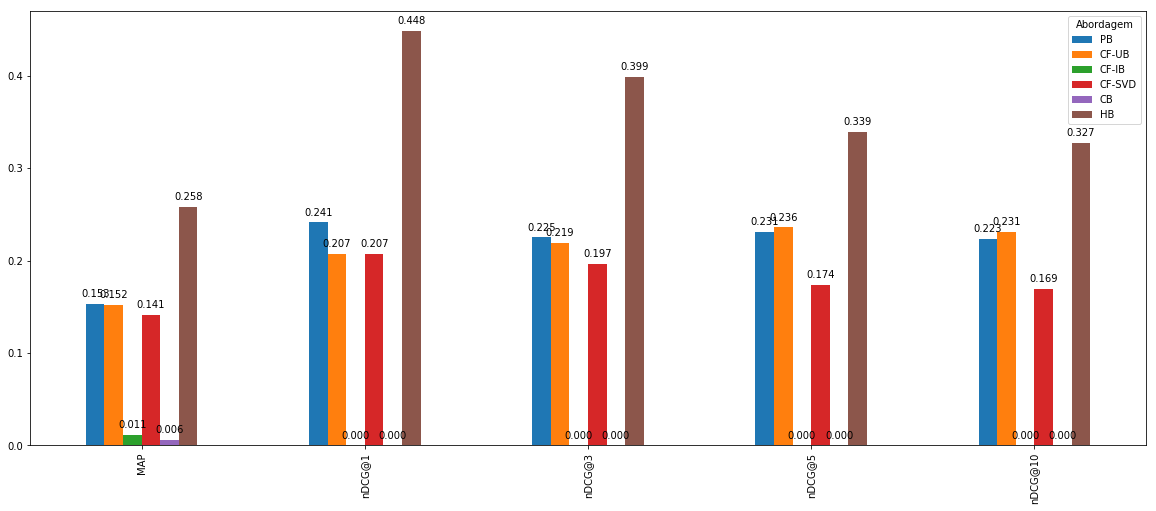

In [218]:
%matplotlib inline
ax = globalRankingMetricsDF.transpose().plot(kind='bar', figsize=(20,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#### *Rating*

---



In [219]:
globalRatingMetricsDF = pd.DataFrame([UBGlobalMetricsRatingDF, IBGlobalMetricsRatingDF, SVDGlobalMetricsRatingDF])
globalRatingMetricsDF = globalRatingMetricsDF[['modelName', 'MAE', 'MSE', 'RMSE']]
globalRatingMetricsDF.columns = ['Abordagem', 'MAE', 'MSE', 'RMSE']
globalRatingMetricsDF = globalRatingMetricsDF.set_index('Abordagem')
globalRatingMetricsDF

,MAE,MSE,RMSE
Abordagem,,,
CF-UB,2.417,19.318,4.395
CF-IB,2.318,18.989,4.358
CF-SVD,2.445,19.387,4.403


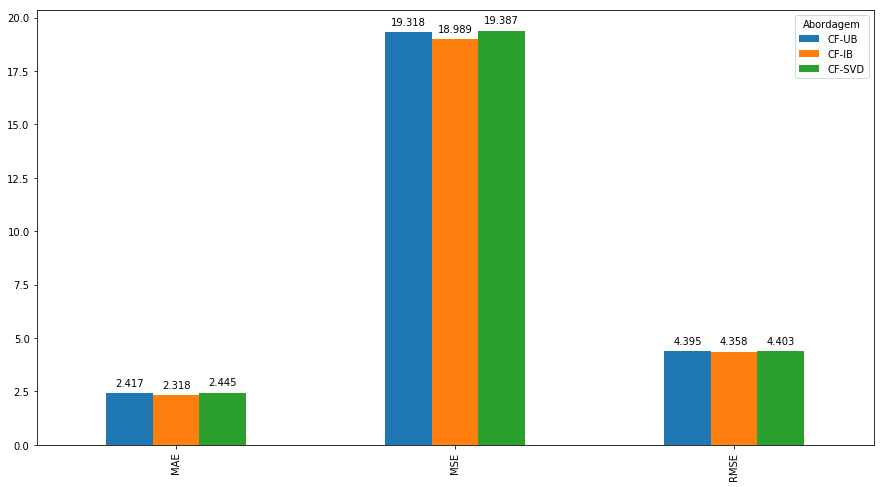

In [220]:
%matplotlib inline
ax = globalRatingMetricsDF.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### Discussões
---
Os resultados da avaliação apresentados acima mostram que a abordagem híbrida foi a que apresentou melhor acurácia.

Vamos verificar o comportamento da melhor abordagem implementada para um usuário específico. Primeiramente, vamos observar os top-$n$ livros que o usuário  se interessou no conjunto de treino:

In [221]:
def inspectRatings(user_id, test_set=True):
    if test_set:
        ratingsDF = ratingsTestIndexedDF        
    else:
        ratingsDF = ratingsTrainIndexedDF
    return ratingsDF.loc[user_id].merge(items, how = 'left', 
                                        left_on = 'BookID', 
                                        right_on = 'BookID') \
                    .sort_values('BookRating', ascending = False)[['BookID','BookTitle','BookRating']]

In [222]:
inspectTop10 = inspectRatings(4017, test_set=False).sort_values(by=['BookRating','BookID'],ascending=False)
inspectTop10 = inspectTop10.iloc[0:10,:] #Selecionando os 10 primeiros da lista
inspectTop10.head(10)

,BookID,BookTitle,BookRating
15,6861,Gap Creek: A Novel,10
7,5331,The Night Listener : A Novel,10
2,4765,The Death of Vishnu: A Novel,10
11,4762,Conversations With God : An Uncommon Dialogue ...,10
13,4747,"The Art of Mending : A Novel (Berg, Elizabeth)",10
6,4730,POSTCARDS,10
4,3420,Chicken Soup for the Teenage Soul II (Chicken ...,10
14,1923,Snow Falling on Cedars,10
3,968,Charming Billy,10
17,716,Strange Fits of Passion: A Novel,10


Agora vamos observar os top-$n$ filmes recomendados pela abordagem híbrida para esse usuário em particular:

In [223]:
recommendedItensHB = HBModel.recommend(4017, topn=10, verbose=True)
#A linha a seguir foi adicionada pois como mais os filmes possuem mais de uma palavra que pode ser relevante para o usuário
#o livro poderia aparecer repetido na lista
recommendedItensHB = recommendedItensHB.drop_duplicates(subset='BookID',keep='first')
recommendedItensHB.sort_values(ascending=False,by=['Score']).head(10)

,BookID,BookTitle,Score
0,1923,Snow Falling on Cedars,7369.678
1,3784,STONES FROM THE RIVER,3380.645
2,648,Angela's Ashes: A Memoir,3249.612
3,5071,Bridget Jones's Diary,2966.432
4,1307,The Color of Water: A Black Man's Tribute to H...,1474.314
5,4578,What Looks Like Crazy On An Ordinary Day,1098.024
6,2545,How to Be Good,810.309
7,7548,Girl in Hyacinth Blue,640.098
8,1485,At Home in Mitford (The Mitford Years),621.981
9,3235,"A Child Called \It\"": One Child's Courage to S...",529.795


## Avaliação da similaridade das recomendações

Uma outra forma de avaliar os sistemas de recomendação é de acordo com a diversidade. A diversidade mede como os itens recomendados diferentes são para um usuário em específico. Essa semelhança é geralmente determinada usando o conteúdo do item (por exemplo gêneros de filmes), mas também pode ser determinada usando como os itens são classificados de maneira semelhante. Uma medida de diversidade é a similaridade intra-lista apresentada por [1] e discutida em [2]. A equação de cálculo da diversidade pode computar a similaridade entre quaisquer dois itens ij e ik. Da mesma forma que a similaridade de cosseno, o coeficiente de similaridade de Jaccard ou outra métrica poderia ser utilizada na equação. Conforme proposto por [3] foi escolhida a similaridade de Jaccard. Segundo o autor, em pequenas listas de tamanho 10 ou 20, o uso da similaridade Jaccard pode ser mais adequado. O índice ou coeficiente de Jaccard é um método estatístico que determina a similaridade entre dois itens a partir da intersecção de seus conjuntos [4]. Essa medida informa o grau de similaridade entre duas listas de recomendação com valores que variam entre 0 (zero) e 1 (um). Caso as listas não possuam nenhum item em comum, o resultado é 0 (zero). O valor aumenta conforme a quantidade de itens em comum cresce. 

[1]	Ziegler, C., McNee, S. M., Konstan, J. A. e Lausen, G. 2005. Improving recommendation lists through topic diversification. In Proceedings of the 14th international conference on World Wide Web (WWW '05). ACM, New York, NY, USA, 22-32. DOI=http://dx.doi.org/10.1145/1060745.1060754.

[2] Beth, A. 2016. Recommender Systems  - It’s Not All About the Accuracy. Disponível em: <https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff>. Acesso em: 03 jul. 2018.

[3] Silva, R. G. N. 2014. Sistema de Recomendação Baseado em Conteúdo Textual: avaliação e comparação.  Dissertação (Mestrado) - Universidade Estadual de Feira de Santana, Universidade Federal da Bahia, Programa Multi–institucional em Ciência da Computação, 2014.

[4]	Levandowsky, M.; Winter, D. 1971. Distance between sets. Nature, v. 234, p. 34-35, Maio, 1971. ISSN 10.1038/234034a0. DOI: http://dx.doi.org/10.1038/234034a0.

In [224]:
#Similaridade Intra-lista das recomendações por popularidade gerada pelo modelo (Usuário teste - 4017)
from sklearn.metrics import jaccard_similarity_score

PBList = recommendedItensPB.drop('BookTitle', axis=1).drop('Score', axis=1)
UBList = recommendedItensUB.drop('BookTitle', axis=1).drop('Score', axis=1)
IBList = recommendedItensIB.drop('BookTitle', axis=1).drop('Score', axis=1)
SVDList = recommendedItensSVD.drop('BookTitle', axis=1).drop('Score', axis=1)
CBList = recommendedItensCB.drop('BookTitle', axis=1).drop('Score', axis=1)
HBList = recommendedItensHB.drop('BookTitle', axis=1).drop('Score', axis=1)

intra_pb_ub_sim = jaccard_similarity_score(PBList, UBList)
intra_pb_ib_sim = jaccard_similarity_score(PBList, IBList)
intra_pb_svd_sim = jaccard_similarity_score(PBList, SVDList)
intra_pb_cb_sim = jaccard_similarity_score(PBList, CBList)
intra_pb_hb_sim = jaccard_similarity_score(PBList, HBList)

intra_ub_ib_sim = jaccard_similarity_score(UBList, IBList)
intra_ub_svd_sim = jaccard_similarity_score(UBList, SVDList)
intra_ub_cb_sim = jaccard_similarity_score(UBList, CBList)
intra_ub_hb_sim = jaccard_similarity_score(UBList, HBList)

intra_ib_svd_sim = jaccard_similarity_score(IBList, SVDList)
intra_ib_cb_sim = jaccard_similarity_score(IBList, CBList)
intra_ib_hb_sim = jaccard_similarity_score(IBList, HBList)

intra_svd_cb_sim = jaccard_similarity_score(SVDList, CBList)
intra_svd_hb_sim = jaccard_similarity_score(SVDList, HBList)

intra_hb_cb_sim = jaccard_similarity_score(HBList, CBList)

print("Similaridade intra-lista (PB - UB): ", intra_pb_ub_sim)
print("Similaridade intra-lista (PB - IB): ", intra_pb_ib_sim)
print("Similaridade intra-lista (PB - SVD): ", intra_pb_svd_sim)
print("Similaridade intra-lista (PB - CB): ", intra_pb_cb_sim)
print("Similaridade intra-lista (PB - HB): ", intra_pb_hb_sim)

print("Similaridade intra-lista (UB - IB): ", intra_ub_ib_sim)
print("Similaridade intra-lista (UB - SVD): ", intra_ub_svd_sim)
print("Similaridade intra-lista (UB - CB): ", intra_ub_cb_sim)
print("Similaridade intra-lista (UB - HB): ", intra_ub_hb_sim)

print("Similaridade intra-lista (IB - SVD): ", intra_ib_svd_sim)
print("Similaridade intra-lista (IB - CB ", intra_ib_cb_sim)
print("Similaridade intra-lista (IB - HB): ", intra_ib_hb_sim)

print("Similaridade intra-lista (SVD - CB): ", intra_svd_cb_sim)
print("Similaridade intra-lista (SVD - HB): ", intra_svd_hb_sim)

print("Similaridade intra-lista (HB - CB): ", intra_hb_cb_sim)


Similaridade intra-lista (PB - UB):  0.4
Similaridade intra-lista (PB - IB):  0.0
Similaridade intra-lista (PB - SVD):  0.0
Similaridade intra-lista (PB - CB):  0.0
Similaridade intra-lista (PB - HB):  0.1
Similaridade intra-lista (UB - IB):  0.0
Similaridade intra-lista (UB - SVD):  0.0
Similaridade intra-lista (UB - CB):  0.0
Similaridade intra-lista (UB - HB):  0.1
Similaridade intra-lista (IB - SVD):  0.0
Similaridade intra-lista (IB - CB  0.0
Similaridade intra-lista (IB - HB):  0.0
Similaridade intra-lista (SVD - CB):  0.0
Similaridade intra-lista (SVD - HB):  0.3
Similaridade intra-lista (HB - CB):  0.0


A mesma verificação de similaridade foi feita comparando-se cada lista gerada pelas abordagens com o TOP 10 na avaliação do usuário.

In [225]:
UserList = inspectTop10.drop('BookTitle', axis=1).drop('BookRating', axis=1)
intra_user_pb_sim = jaccard_similarity_score(UserList, PBList)
intra_user_ub_sim = jaccard_similarity_score(UserList, UBList)
intra_user_ib_sim = jaccard_similarity_score(UserList, IBList)
intra_user_svd_sim = jaccard_similarity_score(UserList, SVDList)
intra_user_cb_sim = jaccard_similarity_score(UserList, CBList)
intra_user_hb_sim = jaccard_similarity_score(UserList, HBList)

print("Similaridade intra-lista (User - UB): ", intra_user_ub_sim)
print("Similaridade intra-lista (User - IB): ", intra_user_ib_sim)
print("Similaridade intra-lista (User - SVD): ", intra_user_svd_sim)
print("Similaridade intra-lista (User - CB): ", intra_user_cb_sim)
print("Similaridade intra-lista (User - HB): ", intra_user_hb_sim)


Similaridade intra-lista (User - UB):  0.0
Similaridade intra-lista (User - IB):  0.0
Similaridade intra-lista (User - SVD):  0.2
Similaridade intra-lista (User - CB):  0.0
Similaridade intra-lista (User - HB):  0.0


## Conclusão
---


Pôde-se observar uma dificuldade considerável na etapa de pré-processamento, principalmente com relação as inconsistências da base e necessidade de enriquecimento de conteúdo textual. Para isso, foi utilizada a Good Book Dataset, para incorporar à Book Crossing palavras-chave dos livros, para posterior aplicação da abordagem de recomendação por conteúdo. No entanto, os resultados não foram os esperados pois nem todos os livros são coincidentes em ambas as bases, assim muitos deles ficaram sem informação textual e tiveram que ser removidos para o processamento da abordagem por conteúdo. Com isso, a base de dados de ratings também teve que ser reduzida neste momento, quando inicialmente ela estava com 17.974 registros, passou a ter 7.181 registros, uma diminuição de 60%.
Outro problema encontrado é com relação a dispersão dos dados. A base de dados Book Crossing é 99,99% esparsa, ou seja, a maioria das avaliações atribuídas é igual a NaN. Como a maioria dos algoritmos de aprendizado de máquina não pode lidar com NaNs, foram substituídos por 0, que indica ausência de classificação e foi denominada avaliação implícita por seu autor. 
Foi feita a tentativa de selecionar apenas as avaliações explícitas, no entanto isso reduziu o número de ratings para 5.423 registros e, no momento da separação da base de dados em treino e teste, essa última teve membros (usuários) com apenas um registro, quando deveria ter pelo menos dois para a divisão correta (erro apontado pelo próprio algoritmo).
Um fato que chamou a atenção foi com relação à idade de alguns usuários. Existem alguns dados de certa forma duvidosos, como usuários com idades acima de 100 anos (366 no total). Como a proposta aqui apresentada não levou em consideração a idade dos usuários, foi mantida a base original. No entanto, recomenda-se atenção neste sentido em caso de abordagens que necessitem da faixa etária para realizar algum tipo de clusterização (agrupamento) de usuários.
A abordagem híbrida foi aquela que apresentou melhores resultados, a partir da combinação das técnicas por popularidade e filtragem colaborativa com fatoração de matrizes. No entanto, existe ainda a necessidade de enriquecimento da base de dados para melhorar os resultados. Outros atributos poderiam ser combinados, como por exemplo o gênero e o resumo do livro. Outras análises poderiam então ser realizadas, como por exemplo a avalição das preferências dos usuários de acordo com a sua localidade. Dessa forma, as abordagens de recomendação poderiam considerar agrupamentos de pessoas para sugerir itens de acordo com as preferências de uma região.
Sobre a base de dados Good Books utilizada neste trabalho, ela não contém dados sobre os usuários, que poderiam criar alternativas para recomendações. Além disso, as palavras-chave nem sempre trazem a informação necessária para se trabalhar o conteúdo nas recomendações. Por exemplo, existem casos de palavras-chave que remetem inclusive ao gênero do filme, como fiction ou adventure, em outras situações aparecem apenas números ou caracteres especiais. No entanto, mesmo com essas limitações, foi possível observar que algumas preferências dos usuários podem ser evidenciadas. Por exemplo, considerando o usuário teste utilizado neste trabalho, ao verificar as palavras-chave dos livros que ele avaliou com notas 9 e 10, identificou-se que é um usuário que gosta de livros de ficção, pois esse termo apareceu em todos eles, mesmo não estando na lista de palavras-chave mais relevantes para ele. No entanto, drama e romance não são indicados para este usuário, já que estes termos não aparecem em suas preferências. Apesar da diversidade da lista de recomendações da abordagem baseada em conteúdo, se comparada as preferências do usuário teste, de 10 itens recomendados, 9 possuem como palavra-chave “ficção”. Assim, é possível que o usuário tenha interesse por estes livros.
Por fim, acredita-se que o propósito de mostrar o desenvolvimento e avaliação de um sistema de recomendação de livros foi cumprido. No entanto, conforme mencionado, outras melhorias nas bases de dados se fazem necessárias para obter tanto uma amostra representativa da população quanto atributos e valores relevantes para a tarefa de recomendação e, consequentemente, melhores resultados das abordagens. Para melhorar as recomendações é necessário encontrar o melhor ajuste para um determinado contexto por meio da avaliação de algoritmos e parametrizações disponíveis.
